# Script for testing segmentation
This script checks the segmentation class and outputs


Pending:
1) Dataloaders pending update to link to Google Bucket


## Imports

In [1]:
import numpy as np
import os

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torchvision import transforms
from torchvision.transforms import ToTensor

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [3]:
from models.segmentation import SegModel

## Temporary dataloader

In [4]:
# Folder locations
dir_input = '../DeepFashionMultimodal_Men/images/'
dir_desired = '../DeepFashionMultimodal_Men/segm/'

In [5]:
#Setting up image parameters
height = 1101
width = 750

In [6]:
#Checking through segmentation library
#Checking all listed files
list_input = []
list_desired = []
for root, dirs, files in os.walk(dir_desired):
   for file in files:
      list_desired.append(os.path.join(root, file))
      list_input.append(dir_input + file[:-9] + '.jpg') 

print(len(list_desired))
print(len(list_input))

1506
1506


In [7]:
class DataLoaderSegm(torch.utils.data.dataset.Dataset):
    def __init__(self, image_files, mask_files):
        super(DataLoaderSegm, self).__init__()
        self.img_files = image_files
        self.label_files = mask_files
        
        self.labels_bg = [0] #Background
        self.labels_head = [13, 14] #Head + Hair
        self.labels_body = list(range(1,13)) + list(range(15,24)) #The rest
        
        # Data augmentation and normalization for training
        # Just normalization for validation
        self.transforms = transforms.Compose([
                    transforms.Resize((height, width)),
                    transforms.ToTensor(),
                ])

    def __getitem__(self, index):
            img_path = self.img_files[index]
            label_path = self.label_files[index]

            image = Image.open(img_path)
            label = Image.open(label_path)

            # Concatenate image and label, to apply same transformation on both
            image_np = np.asarray(image)
            label_np = np.asarray(label)

            #Convert to 3 class
            label_np2 = np.zeros(label_np.shape, dtype=np.uint8)
            label_np2 = np.isin(label_np, self.labels_head)*1 + np.isin(label_np, self.labels_body)*2 

            new_shape = (image_np.shape[0], image_np.shape[1], image_np.shape[2] + 1)
            image_and_label_np = np.zeros(new_shape, image_np.dtype)
            image_and_label_np[:, :, 0:3] = image_np
            image_and_label_np[:, :, 3] = label_np2

            # Convert to PIL
            image_and_label = Image.fromarray(image_and_label_np)
            
            # Apply Transforms
            image_and_label = self.transforms(image_and_label)

            # Extract image and label
            image = image_and_label[0:3, :, :]
            label = image_and_label[3, :, :].unsqueeze(0)

            # Normalize back from [0, 1] to [0, 255]
            label = label * 255
            label = label.long().squeeze()

            return image, label

    def __len__(self):
        return len(self.img_files)

In [8]:
FashionDataset={
    'img': DataLoaderSegm(list_input, list_desired)
}

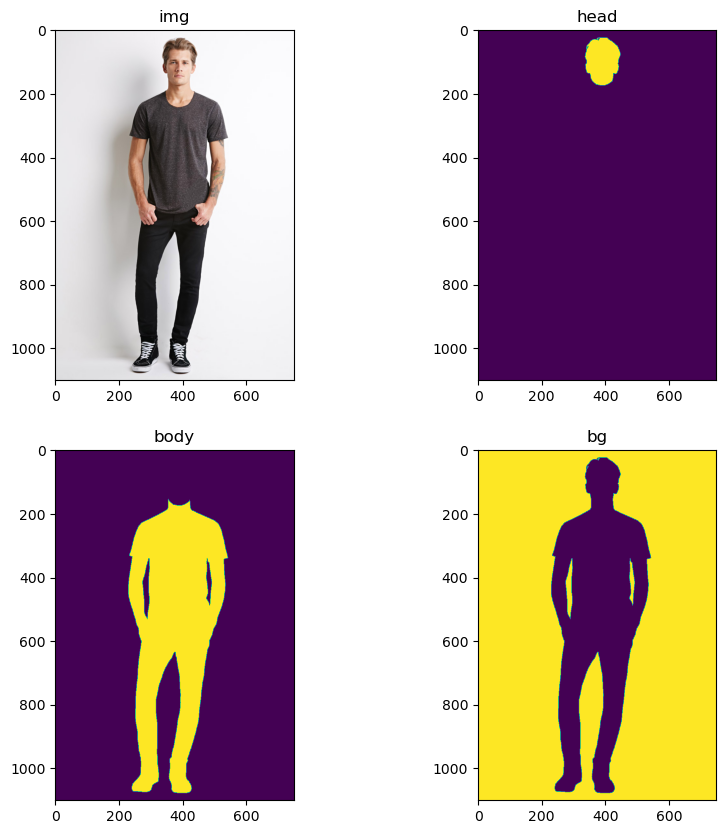

In [9]:
# Unit test for Sample display
img, lab = FashionDataset['img'][0]
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Display the LR and HR images using matplotlib
axs[0,0].imshow(img.permute((1,2,0)))
axs[0,0].set_title('img')
axs[0,1].imshow(lab==1)
axs[0,1].set_title('head')
axs[1,0].imshow(lab==2)
axs[1,0].set_title('body')
axs[1,1].imshow(lab==0)
axs[1,1].set_title('bg')

plt.show()

## Loading model

In [10]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [11]:
def initialize_model(num_classes, keep_feature_extract=False, use_pretrained=True):
    """ DeepLabV3 pretrained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.
    """
    model_deeplabv3 = models.segmentation.deeplabv3_resnet50(pretrained=use_pretrained, progress=True)
    model_deeplabv3.aux_classifier = None
    if keep_feature_extract:
        for param in model_deeplabv3.parameters():
            param.requires_grad = False

    input_size = img.shape
    model_deeplabv3.classifier = torchvision.models.segmentation.deeplabv3.DeepLabHead(2048, num_classes)

    return model_deeplabv3, input_size

In [12]:
model_segm = SegModel().to(device)
#model_segm, input_size = initialize_model(3, keep_feature_extract=False, use_pretrained=True)

C:\Users\Athrun\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Athrun\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Evaluation

In [13]:
im, lab = FashionDataset['img'][25]
bg, body, head = model_segm.forward(im.unsqueeze(0).to(device))


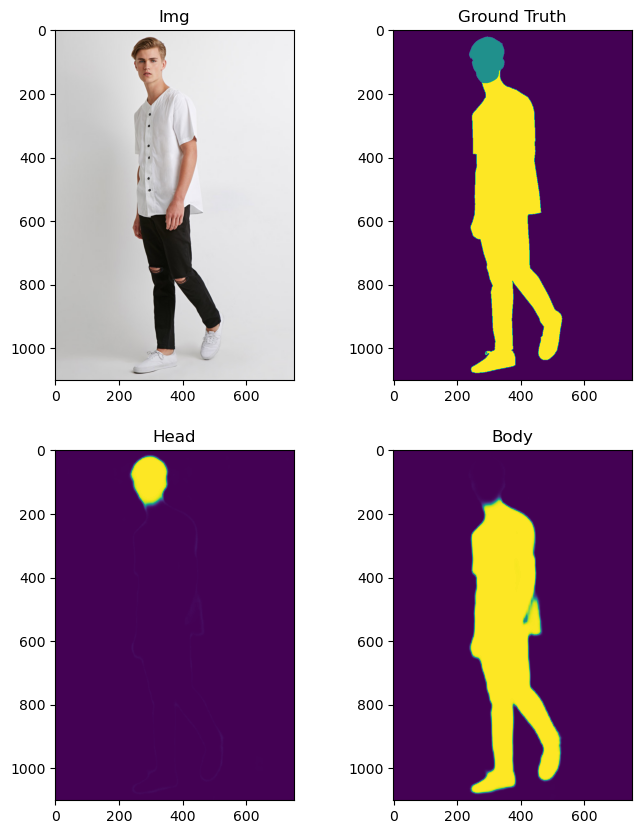

In [14]:

#Sample display
fig, axs = plt.subplots(2, 2, figsize=(8, 10))

# Display the LR and HR images using matplotlib
axs[0,0].imshow(im.permute((1,2,0)))
axs[0,0].set_title('Img')
axs[0,1].imshow(lab)
axs[0,1].set_title('Ground Truth')
axs[1,0].imshow(head.squeeze(0).squeeze(0).detach().cpu())
axs[1,0].set_title('Head')
axs[1,1].imshow(body.squeeze(0).squeeze(0).detach().cpu())
axs[1,1].set_title('Body')

plt.show()
